In [1]:
import dicom
import os
import numpy as np
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image
from scipy.misc import imrotate

In [2]:
import nibabel as nib

In [2]:
#Put Data Paths

Function to get the eigen vector for the image orientation

Method 1: First perfor Orientation_M1. Then do get_NewOrientation and store the output to get the eigen vectors for the image. Take Orientation_M1 output and feed it into reScale. Take reScale output and make it the input into get_square_crop. Last step is contrast. Once that is done, get the shape of the image and save that to get the new image size. 

In [3]:
#Orientation
def Orientation_flip180 (img):
        #new_img=cv2.transpose(img.pixel_array)
        #py.imshow(img_new)
        Fliped_new_img = cv2.flip(img,-1)
        return Fliped_new_img

In [4]:
#Function of Rescaling the pixels after Orientation
def reScale(img, scale):
    return cv2.resize(img, (0, 0), fx=scale, fy=scale)

In [5]:
#After Rescaling; get square crop
def get_square_crop(img, base_size=256, crop_size=256):
    res = img
    height, width = res.shape
    print(height)
    print(width)
    if height < base_size:
        diff = base_size - height
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, extend_top, extend_bottom, 0, 0, borderType=cv2.BORDER_CONSTANT, value=0)
        height = base_size

    if width < base_size:
        diff = base_size - width
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, 0, 0, extend_top, extend_bottom, borderType=cv2.BORDER_CONSTANT, value=0)
        width = base_size

    crop_y_start = int((height - crop_size) / 2)
    print(crop_y_start)
    crop_x_start = int((width - crop_size) / 2)
    print(crop_x_start)
    res = res[crop_y_start:(crop_y_start + crop_size), crop_x_start:(crop_x_start + crop_size)]
    return res

In [6]:
#contrast Change; perform after get_square_crop
def contrast(img):
    clahe = cv2.createCLAHE(tileGridSize=(1, 1))
    return clahe.apply(img)

In [9]:
nim1 = nib.load('../Data/patient004_slice4_frame1.nii')
#Label original
nim1label=nib.load('../Data/patient004_slice4_frame1_label.nii')

In [10]:
print(nim1)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (232, 256)
affine: 
[[  -1.3671875     0.            0.          157.91015625]
 [   0.            1.3671875     0.         -174.31640625]
 [   0.            0.           10.          -45.        ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 16384
session_error   : 0
regular         : r
dim_info        : 0
dim             : [  2 232 256   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ -1.          1.3671875   1.3671875  10.          1.          1.          1.
   1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 1059.0
cal_min    

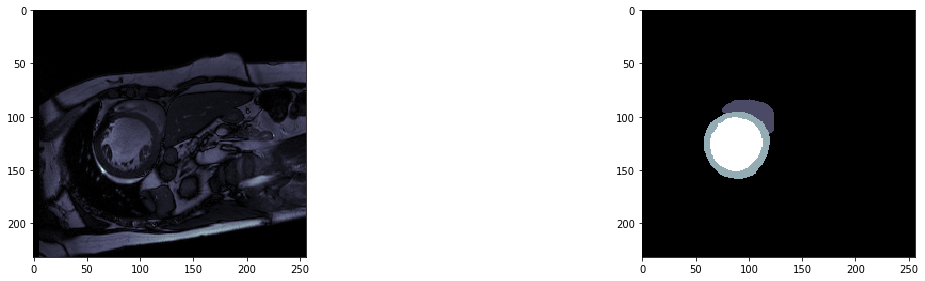

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(nim1.get_data(), cmap="bone")
plt.subplot(222)
plt.imshow(nim1label.get_data(), cmap="bone")

In [12]:
#180 degree flip
flipped_img=Orientation_flip180(nim1.get_data())
flipped_label=Orientation_flip180(nim1label.get_data())

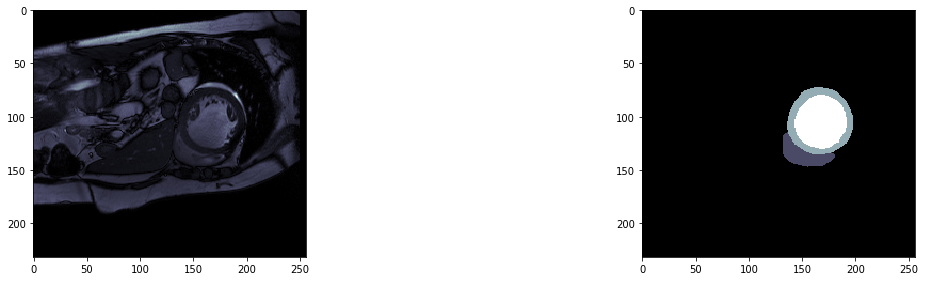

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(flipped_img, cmap="bone")
plt.subplot(222)
plt.imshow(flipped_label, cmap="bone")

In [47]:
# scaledImg=reScale(nim1.get_data(), 1.3671875)
scaledImg=reScale(flipped_img, 1.3671875)
# scaledLabel=reScale(nim1label.get_data(), 1.3671875)
scaledLabel=reScale(flipped_label, 1.3671875)

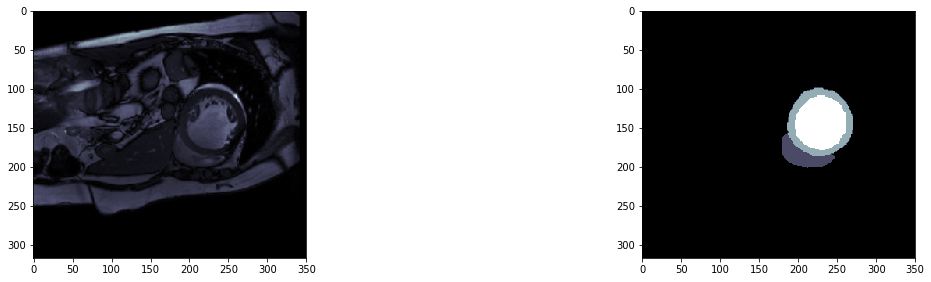

In [48]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(scaledImg, cmap="bone")
plt.subplot(222)
plt.imshow(scaledLabel, cmap="bone")

In [49]:
Cropped_img=get_square_crop(scaledImg)
Cropped_Label=get_square_crop(scaledLabel)
type(Cropped_img)

317
350
30
47
317
350
30
47


numpy.ndarray

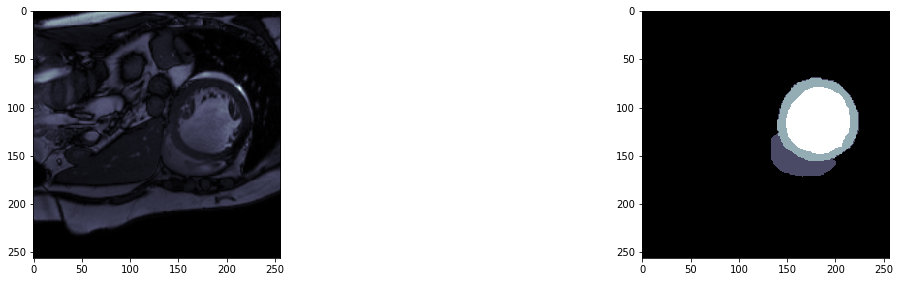

In [50]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(Cropped_img, cmap="bone")
plt.subplot(222)
plt.imshow(Cropped_Label, cmap="bone")

In [51]:
Cropped_img = np.array(Cropped_img, dtype=np.uint16)
contrast_img=contrast(Cropped_img)
Cropped_Label = np.array(Cropped_Label, dtype=np.uint16)
contrast_label=contrast(Cropped_Label)

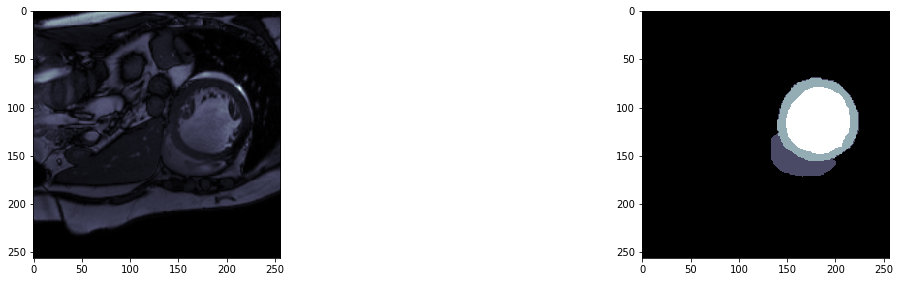

In [52]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(Cropped_img, cmap="bone")
plt.subplot(222)
plt.imshow(Cropped_Label, cmap="bone")

Method 2: Perform getAlignImg and then do get_NewOrientation and save the output. Take the output from getAlignImg and feed it into crop_size. The img_L input will be consistent for all the images. It needs to be the minimum of the most common image size for all the slices / frames. Then save the shape of the image to see if the images are the same size. 

In [ ]:
#Orientation around theta and contrast normalization
def getAlignImg(t,label = None):#!!!notice, only take uint8 type for the imrotate function!!!
    f = lambda x:np.asarray([float(a) for a in x]);
    o = f(t.ImageOrientationPatient);
    o1 = o[:3];
    o2 = o[3:];
    oh = np.cross(o1,o2);
    or1 = np.asarray([0.6,0.6,-0.2]);
    o2new = np.cross(oh,or1);
    theta = np.arccos(np.dot(o2,o2new)/np.sqrt(np.sum(o2**2)*np.sum(o2new**2)))*180/3.1416;
    theta = theta * np.sign(np.dot(oh,np.cross(o2,o2new)));
    im_max = np.percentile(t.pixel_array.flatten(),99);
    res = imrotate(np.array(np.clip(np.array(t.pixel_array,dtype=np.float)/im_max*256,0,255),dtype=np.uint8),theta);
    if label is None:
        return res;
    else:
        lab = imrotate(label,theta);
        return res,lab

In [25]:
img_L=int(np.min(180)) #NEEDS to be the most common minimum image shape for all the slices
#replaced res with flipped image

In [62]:
def contrast(img):
    im_max=np.percentile(img.flatten(),99)
    res = np.array(np.clip(np.array(flipped_img,dtype=np.float)/im_max*256,0,255),dtype=np.uint8)
    return res

In [63]:
def crop_size(res, img_L):
    shift  = np.array([0,0]) 
    if res.shape[0]>res.shape[1]:
        s = (res.shape[0]-res.shape[1])//2;
        res = res[s:s+res.shape[1],:];
        shift[1] = s;
    else:
        s = (res.shape[1]-res.shape[0])//2;
        res = res[:,s:s+res.shape[0]];
        shift[0] = s;

        #crop or stretch to the same size
    if img_L>0 and (res.shape[0] != img_L):
        #print("crop or fill",filename);
        if res.shape[0]>img_L:#because h=w after crop
            s = (res.shape[0]-img_L)//2;
            res = res[s:s+img_L,s:s+img_L];
            shift = shift + s;
        else:
            s = (img_L-res.shape[0])//2;
            res2 = np.zeros((self.img_L,img_L));
            res2[s:s+res.shape[0],s:s+res.shape[0]] = res;
            res = res2;
            shift = shift - s;
    return res

In [59]:
im_max=np.percentile(flipped_img.flatten(),99)
res = np.array(np.clip(np.array(flipped_img,dtype=np.float)/im_max*256,0,255),dtype=np.uint8)

In [74]:
method2Contrast_img=contrast(flipped_img)
method2Img=crop_size(method2Contrast_img,img_L)
# method2Contrast_label=contrast(flipped_label)
method2Label=crop_size(flipped_label,img_L)

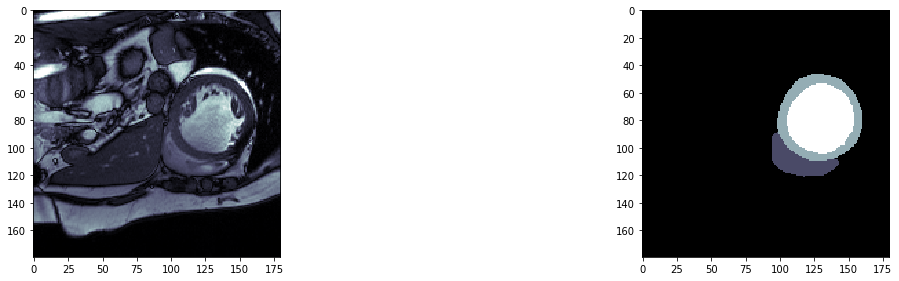

In [75]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(method2Img, cmap="bone")
plt.subplot(222)
plt.imshow(method2Label, cmap="bone")

In [72]:
method2Img=crop_size(flipped_img,img_L)
method2Label=crop_size(flipped_label,img_L)

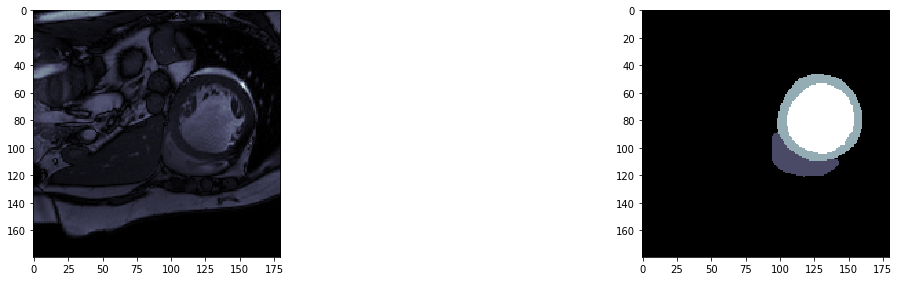

In [73]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(method2Img, cmap="bone")
plt.subplot(222)
plt.imshow(method2Label, cmap="bone")